**Emotion Detection in Tweets - LSTM Model from Scratch**

# SETUP for Colab

In [1]:
!pip install wordcloud

# Import **Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from wordcloud import WordCloud
import os

# Load Dataset (Upload Files)

In [3]:
from google.colab import files
uploaded = files.upload()

# Load train / val / test
train_df = pd.read_csv('/content/train.txt', sep=';', names=['text', 'label'])
val_df = pd.read_csv('/content/val.txt', sep=';', names=['text', 'label'])
test_df = pd.read_csv('/content/test.txt', sep=';', names=['text', 'label'])

Saving test.txt to test (1).txt
Saving train.txt to train (1).txt
Saving val.txt to val (1).txt


# EDA

In [26]:
# Number of samples
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Train samples: 16000
Validation samples: 2000
Test samples: 2000


In [27]:
# Unique classes
print("Classes:", train_df['label'].unique())

Classes: ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


In [41]:
# Unique classes
print("Classes:", test_df['label'].unique())

Classes: ['sadness' 'joy' 'fear' 'anger' 'love' 'surprise']


In [42]:
# Unique classes
print("Classes:", val_df['label'].unique())

Classes: ['sadness' 'love' 'anger' 'joy' 'fear' 'surprise']


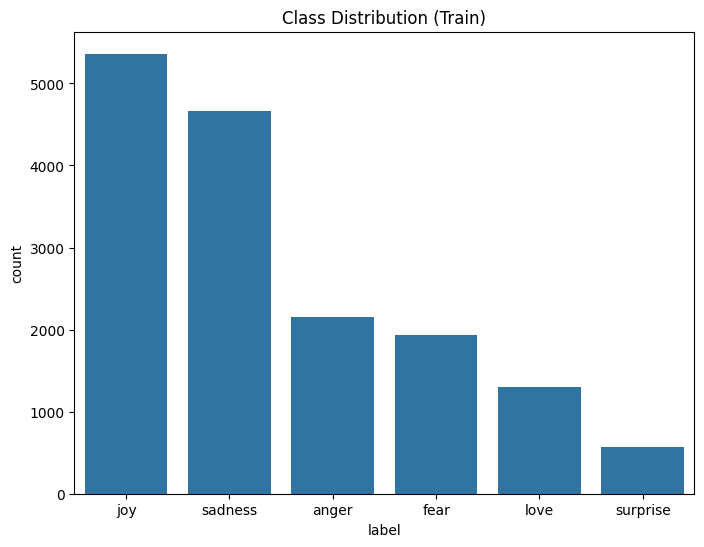

In [28]:
# Class balance
plt.figure(figsize=(8,6))
sns.countplot(data=train_df, x='label', order=train_df['label'].value_counts().index)
plt.title('Class Distribution (Train)')
plt.show()

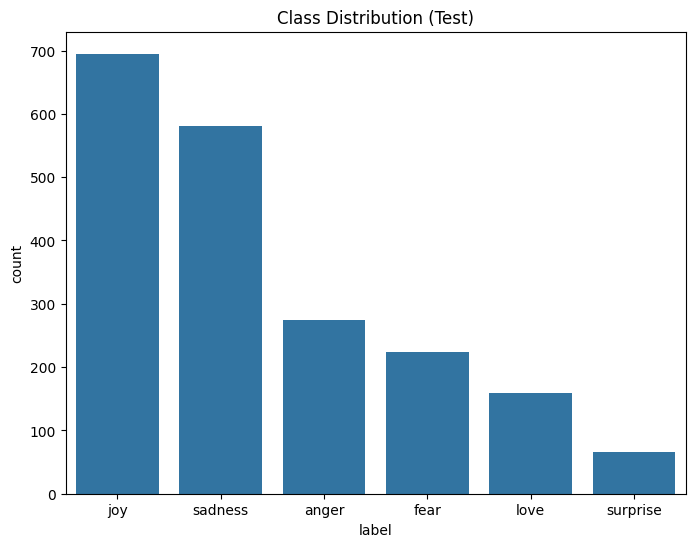

In [39]:
# Class balance
plt.figure(figsize=(8,6))
sns.countplot(data=test_df, x='label', order=test_df['label'].value_counts().index)
plt.title('Class Distribution (Test)')
plt.show()

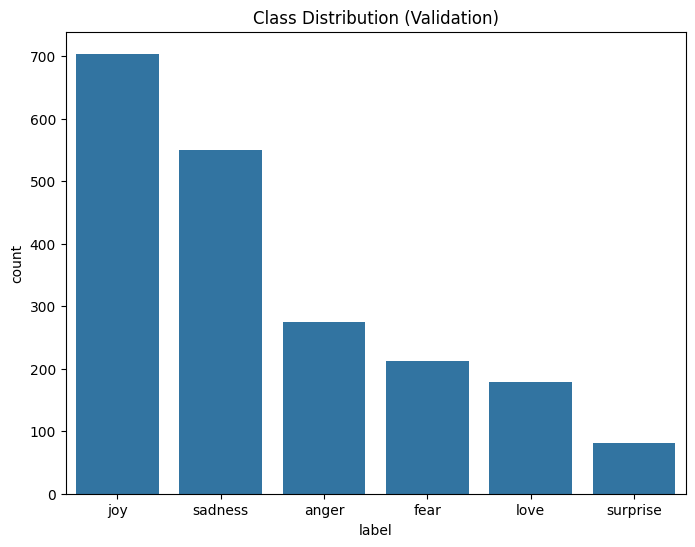

In [40]:
# Class balance
plt.figure(figsize=(8,6))
sns.countplot(data=val_df, x='label', order=val_df['label'].value_counts().index)
plt.title('Class Distribution (Validation)')
plt.show()

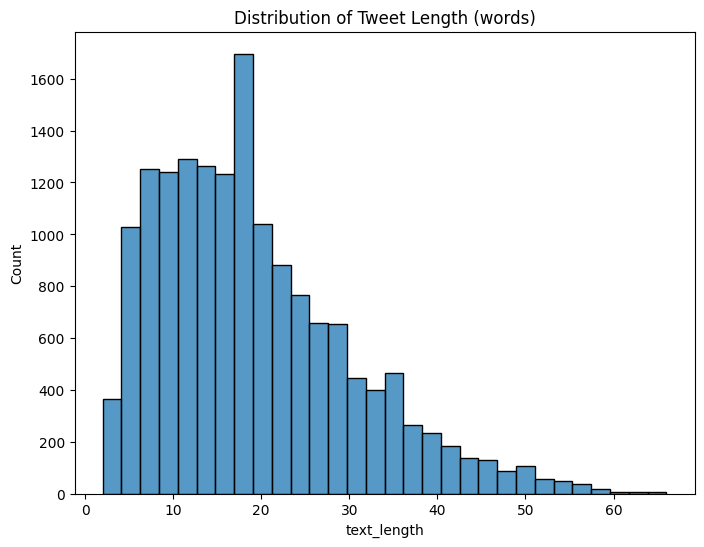

In [29]:
# Text length distribution
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,6))
sns.histplot(train_df['text_length'], bins=30)
plt.title('Distribution of Tweet Length (words)')
plt.show()

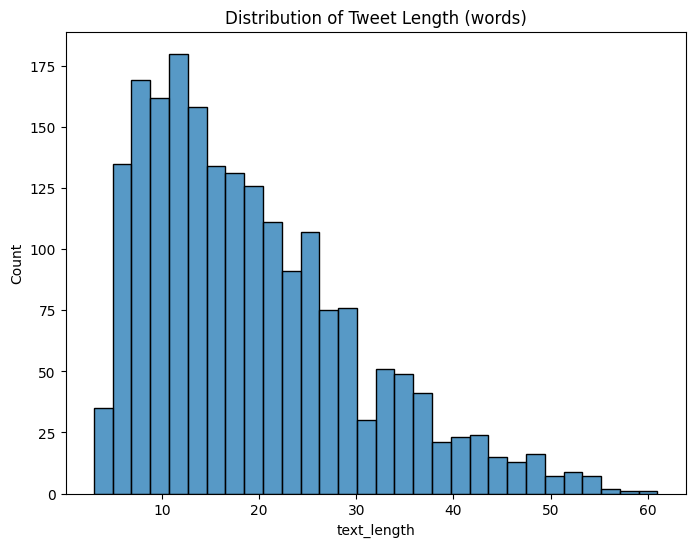

In [36]:
# Text length distribution
test_df['text_length'] = test_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,6))
sns.histplot(test_df['text_length'], bins=30) # Changed to use test_df and the correct column name
plt.title('Distribution of Tweet Length (words)')
plt.show()

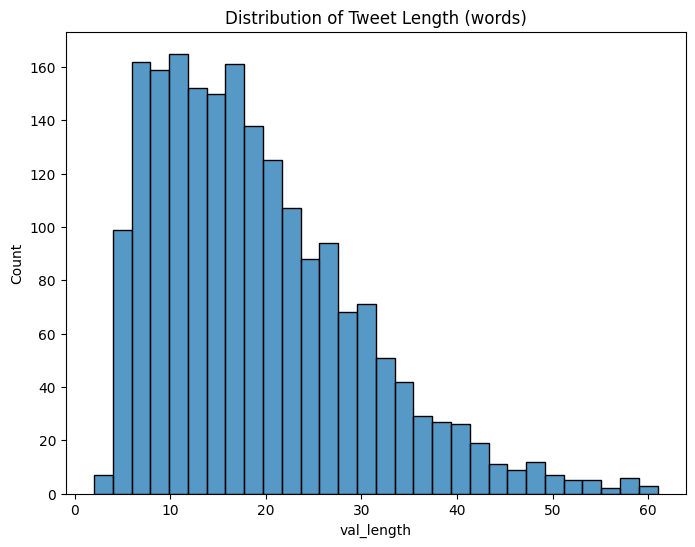

In [38]:
# Validation length distribution
# Calculate the text length for the 'text' column in the val_df DataFrame
val_df['val_length'] = val_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,6))
sns.histplot(val_df['val_length'], bins=30)
plt.title('Distribution of Tweet Length (words)')
plt.show()

In [30]:
# Example per class
for label in train_df['label'].unique():
    print(f"\nLabel: {label}")
    print(train_df[train_df['label'] == label]['text'].sample(1).values[0])


Label: sadness
i am feeling pretty stinkin shitty for being such a horrible reviewer

Label: anger
im feeling queezy and cant be bothered putting these in order so here goes

Label: love
ive been feeling passionate about local business lately and i do like to walk through consignment stores and second hand shops just as much as i enjoy goodwill

Label: surprise
i feel a bit stunned actually

Label: fear
i ignored her minor tantrum and jumped down from the table beginning to pace again and feeling agitated

Label: joy
i currently have it sitting in a bowl of rice in the sun in the hope it will dry out but im not feeling optimistic


In [33]:
# Example per class
for label in test_df['label'].unique():
    print(f"\nLabel: {label}")
    # Access the 'text' column instead of the non-existent 'test' column
    print(test_df[test_df['label'] == label]['text'].sample(1).values[0])


Label: sadness
i feel like a loser everyone says they lost but i dont i know exactly where i am i just hate being here oh

Label: joy
im feeling more lively than yesterday still not sure about food though

Label: fear
i feel like in the last year especially i ve gone from a girl to a woman and despite how hesitant i have always been about getting older next year i will be twenty four i am surprised at how pleased i am to have done so

Label: anger
i feel completely rude with not keeping up with some of you over the course of the year but it has been a mightily busy one

Label: love
i feel like a naughty school girl because i am falling behind

Label: surprise
i purple month doesnt feel surprised in fact zhuo feng up many pupils all clear xiao her identity dont even say main star feng of young


In [34]:
# Example per class
for label in val_df['label'].unique():
    print(f"\nLabel: {label}")
    # Access the 'text' column instead of the non-existent 'test' column
    print(val_df[val_df['label'] == label]['text'].sample(1).values[0])


Label: sadness
i won t feel like there would be a dull moment with him

Label: love
i feel strangely sympathetic towards the citizens of the capitol for some reason and the cast s overall chemistry was good the look and feel of the movie was great and i found the story to be engaging and interesting enough to be watchable

Label: anger
i have a train case full of pretty make up and a drawer full of great hair products but each morning i feel bothered to do little more then lather my face with lotion before heading out for work

Label: joy
i feel practically virtuous this month i have not exceeded my target of only buying things

Label: fear
i started to question whether or not i was on course because i was feeling that confused

Label: surprise
i was willing to be honest with myself and put a name to what i was feeling i was shocked


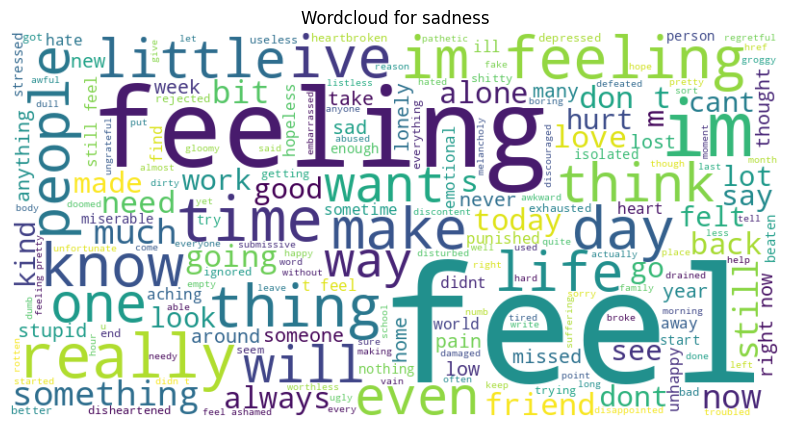

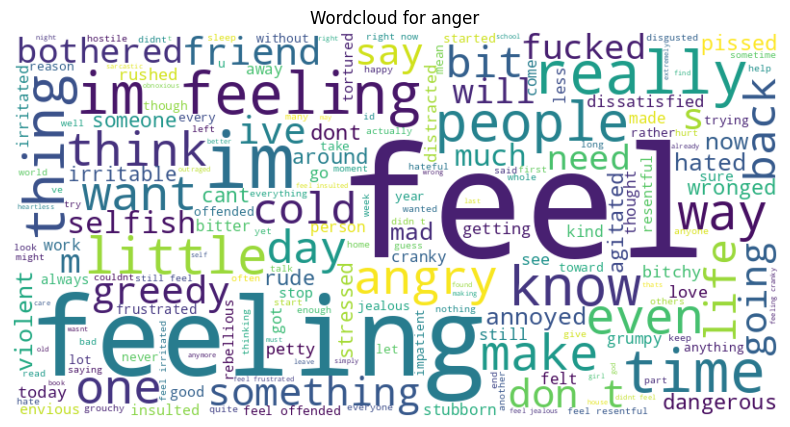

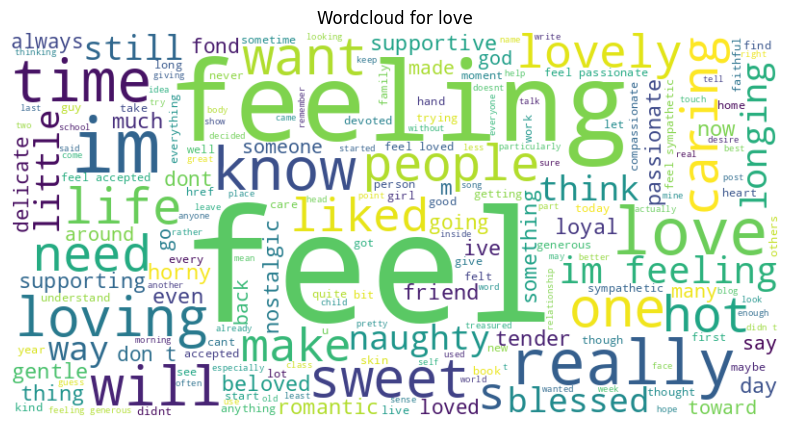

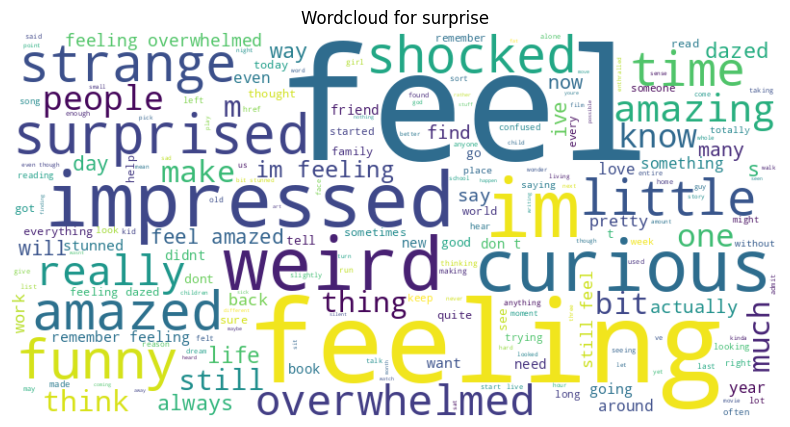

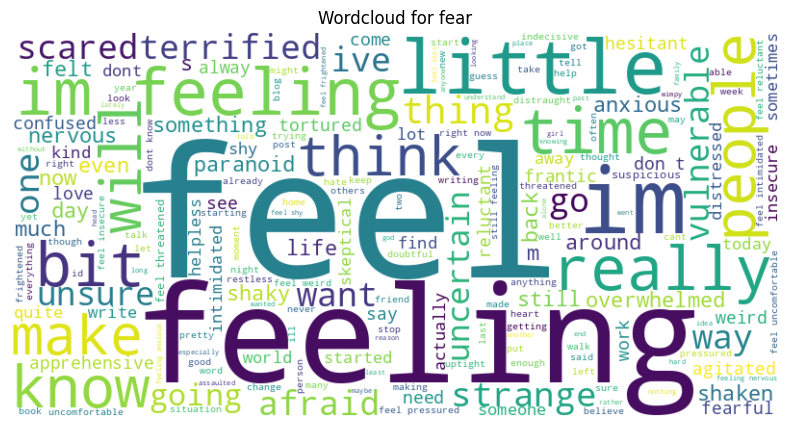

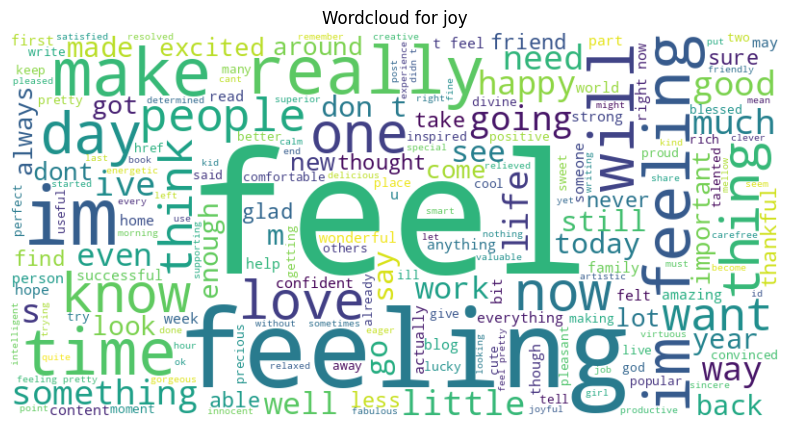

In [10]:
# Wordclouds
for label in train_df['label'].unique():
    text = " ".join(train_df[train_df['label'] == label]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Wordcloud for {label}")
    plt.show()

## Checking null and removing Duplicates in train

In [43]:
print(train_df.isnull().sum())
print(train_df.duplicated().sum())

# removing Duplicates
index = train_df[train_df.duplicated()==True].index
train_df.drop(index , axis =0 ,inplace=True)
train_df.reset_index(inplace=True, drop=True)

print(train_df.duplicated().sum())

text           0
label          0
text_length    0
clean_text     0
dtype: int64
1
0


## Checking null and removing Duplicates in test

In [44]:
print(test_df.isnull().sum())
print(test_df.duplicated().sum())

text           0
label          0
clean_text     0
text_length    0
dtype: int64
0


## Checking null and removing Duplicates in val

In [45]:
print(val_df.isnull().sum())
print(val_df.duplicated().sum())

text          0
label         0
clean_text    0
val_length    0
dtype: int64
0


In [46]:
#text lengths
train_df['text_len'] = train_df['text'].apply(lambda x: len(x.split()))
val_df['text_len'] = val_df['text'].apply(lambda x: len(x.split()))
test_df['text_len'] = test_df['text'].apply(lambda x: len(x.split()))

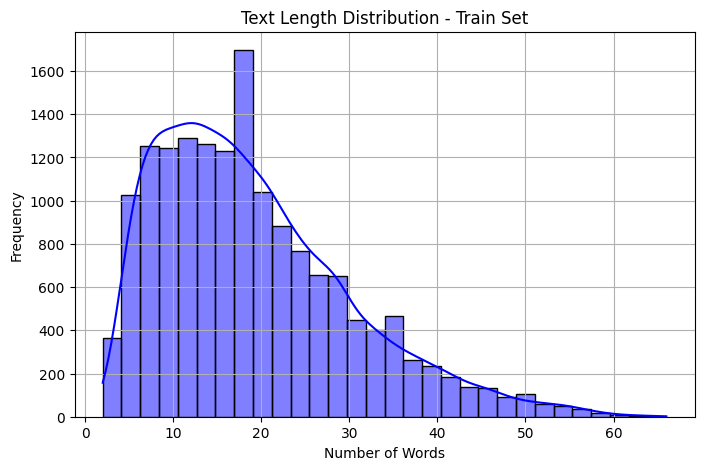

In [47]:
#Train Set
plt.figure(figsize=(8, 5))
sns.histplot(train_df['text_len'], bins=30, kde=True, color='blue')
plt.title("Text Length Distribution - Train Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

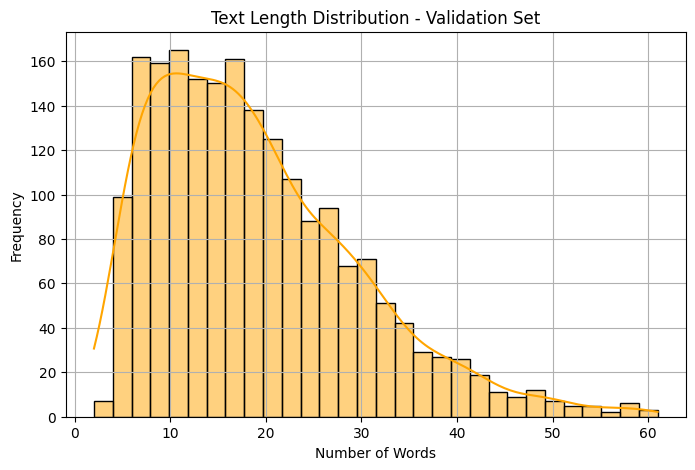

In [48]:
#Validation Set
plt.figure(figsize=(8, 5))
sns.histplot(val_df['text_len'], bins=30, kde=True, color='orange')
plt.title("Text Length Distribution - Validation Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

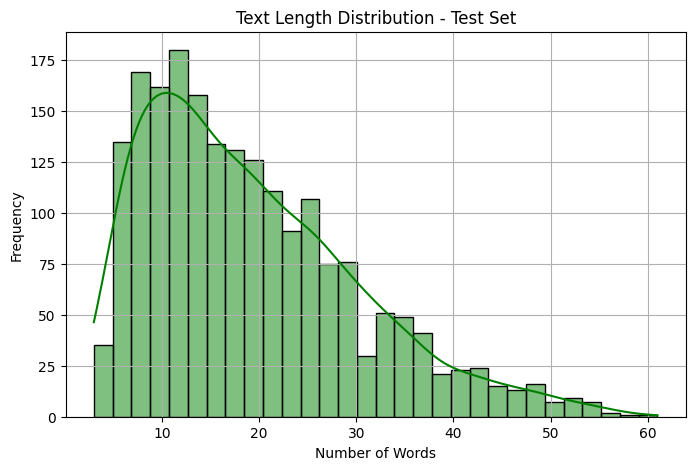

In [49]:
# Test Set
plt.figure(figsize=(8, 5))
sns.histplot(test_df['text_len'], bins=30, kde=True, color='green')
plt.title("Text Length Distribution - Test Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

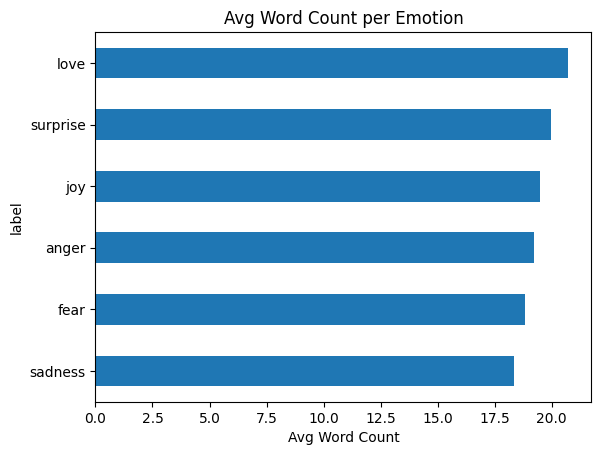

In [50]:
# Words
train_df.groupby('label')['text_len'].mean().sort_values().plot(kind='barh', title="Avg Word Count per Emotion")
plt.xlabel("Avg Word Count")
plt.show()

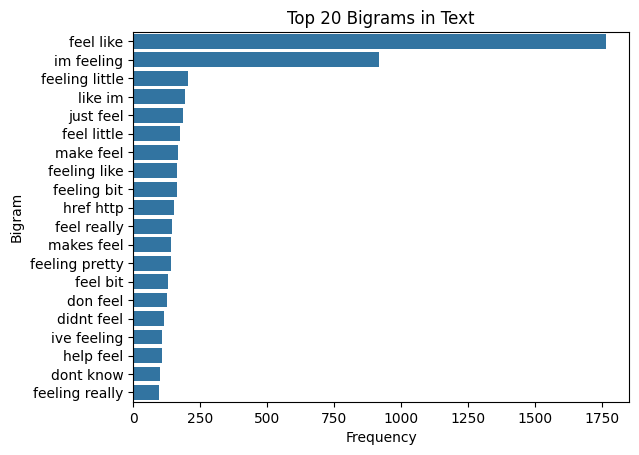

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(train_df['text'])
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Plot top 20 bigrams
top_20_bigrams = words_freq[:20]
bigrams_df = pd.DataFrame(top_20_bigrams, columns=['Bigram', 'Frequency'])
sns.barplot(y='Bigram', x='Frequency', data=bigrams_df)
plt.title("Top 20 Bigrams in Text")
plt.show()

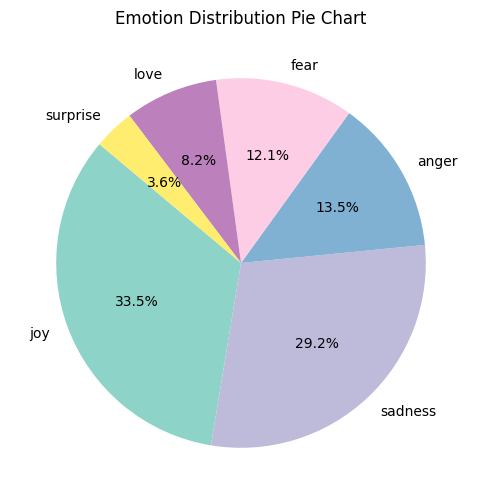

In [52]:
plt.figure(figsize=(6, 6))
train_df['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, cmap='Set3')
plt.title("Emotion Distribution Pie Chart")
plt.ylabel('')
plt.show()

### identification of outliers

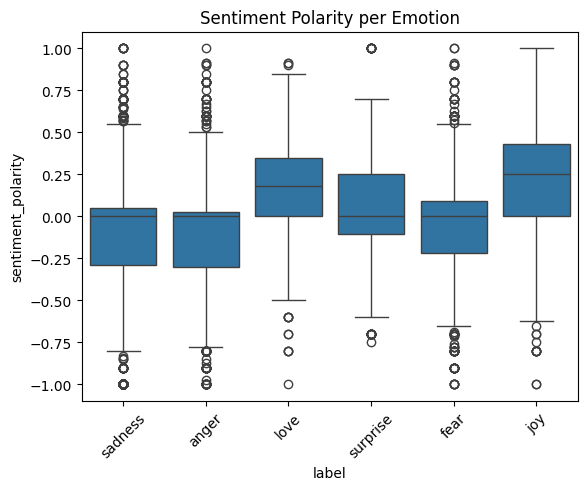

In [53]:
from textblob import TextBlob

train_df['sentiment_polarity'] = train_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

sns.boxplot(data=train_df, x='label', y='sentiment_polarity')
plt.xticks(rotation=45)
plt.title("Sentiment Polarity per Emotion")
plt.show()

# Preprocessing

### Comparision of rows in Dataset

####Define the dataframe_difference function:

In [63]:
def dataframe_difference(df1, df2, which=None):
    """
    Find rows which are different between two DataFrames.
    """
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
    return diff_df


#### function to compare train/val/test sets for overlaps:

In [64]:
print("Checking overlap between train and test:")
print(dataframe_difference(train_df, test_df, which='both'))

print("Checking overlap between train and validation:")
print(dataframe_difference(train_df, val_df, which='both'))

print("Checking overlap between validation and test:")
print(dataframe_difference(val_df, test_df, which='both'))

Checking overlap between train and test:
                              text    label  text_length  \
2576                   feel better      joy            4   
3096                 feel defeated  sadness            4   
3128                feel depressed  sadness            4   
6525               feel passionate      joy            5   
7826                   feel tender     love            4   
8050                 feel troubled  sadness            4   
12432  ive feeling listless lately  sadness            6   

                        clean_text  text_len  sentiment_polarity _merge  
2576                   feel better         4               0.500   both  
3096                 feel defeated         4               0.000   both  
3128                feel depressed         4               0.000   both  
6525               feel passionate         5               0.225   both  
7826                   feel tender         4               0.000   both  
8050                 feel troubled

#### Remove overlapping rows from validation and test sets

In [65]:
# Remove overlapping rows in validation
overlap_train_val = dataframe_difference(train_df, val_df, which='both')
val_df = val_df[~val_df['text'].isin(overlap_train_val['text'])]


In [66]:
# Remove overlapping rows in test
overlap_train_test = dataframe_difference(train_df, test_df, which='both')
test_df = test_df[~test_df['text'].isin(overlap_train_test['text'])]


### Cleaning the Dataset

#### Import NLTK and download required corpora:

In [67]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [68]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Define text cleaning functions:

In [69]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()
    text = text.split()
    text=[lemmatizer.lemmatize(y) for y in text]
    return " ".join(text)

def remove_stop_words(text):
    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    text = text.split()
    text=[y.lower() for y in text]
    return " ".join(text)

def Removing_punctuations(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"")
    text = re.sub('\s+', ' ', text)
    text = " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


#### Apply normalization pipeline to train, val, test sets:

In [70]:
def normalize_text(df, col_name):
    df[col_name] = df[col_name].apply(lower_case)
    df[col_name] = df[col_name].apply(remove_stop_words)
    df[col_name] = df[col_name].apply(Removing_numbers)
    df[col_name] = df[col_name].apply(Removing_punctuations)
    df[col_name] = df[col_name].apply(Removing_urls)
    df[col_name] = df[col_name].apply(lemmatization)
    return df

# Apply normalization
train_df = normalize_text(train_df, 'text')
val_df = normalize_text(val_df, 'text')
test_df = normalize_text(test_df, 'text')

<ipython-input-70-a5aebbc59d34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df[col_name].apply(lower_case)
<ipython-input-70-a5aebbc59d34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = df[col_name].apply(remove_stop_words)
<ipython-input-70-a5aebbc59d34>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [71]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

train_df['clean_text'] = train_df['text'].apply(clean_text)
val_df['clean_text'] = val_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

<ipython-input-71-0089d0dea604>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['clean_text'] = test_df['text'].apply(clean_text)


#### Alternative clean_text function (simpler cleaning):

In [72]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

train_df['clean_text'] = train_df['text'].apply(clean_text)
val_df['clean_text'] = val_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)


<ipython-input-72-0089d0dea604>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['clean_text'] = test_df['text'].apply(clean_text)


#### Initialize tokenizer:

In [73]:
MAX_VOCAB = 10000
MAX_LEN = 50

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])

#### Convert texts to padded sequences:

In [74]:
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['clean_text']), maxlen=MAX_LEN)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_df['clean_text']), maxlen=MAX_LEN)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['clean_text']), maxlen=MAX_LEN)

#### Encode labels to categorical:

In [75]:
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label'])

y_train = to_categorical(label_encoder.transform(train_df['label']))
y_val = to_categorical(label_encoder.transform(val_df['label']))
y_test = to_categorical(label_encoder.transform(test_df['label']))

# Build Model

In [15]:
EMBEDDING_DIM = 100

model = Sequential()
model.add(Embedding(input_dim=MAX_VOCAB, output_dim=EMBEDDING_DIM, input_length=MAX_LEN))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


# Train Model

In [16]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 148ms/step - accuracy: 0.4037 - loss: 1.4980 - val_accuracy: 0.8320 - val_loss: 0.5128
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 54s 107ms/step - accuracy: 0.8977 - loss: 0.3292 - val_accuracy: 0.9220 - val_loss: 0.2406
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 98ms/step - accuracy: 0.9539 - loss: 0.1356 - val_accuracy: 0.9235 - val_loss: 0.2131
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 94ms/step - accuracy: 0.9697 - loss: 0.0909 - val_accuracy: 0.9245 - val_loss: 0.2571
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - accuracy: 0.9718 - loss: 0.0751 - val_accuracy: 0.9305 - val_loss: 0.2256
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - accuracy: 0.9813 - loss: 0.0529 - val_accuracy: 0.9305 - val_loss: 0.2395
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 95ms/step - accuracy: 0.9852 - loss: 0.0423 - val_accuracy: 0.9205 - val_loss: 0.2981
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - accuracy: 0.9860 - loss: 0.0397 

# Evaluation

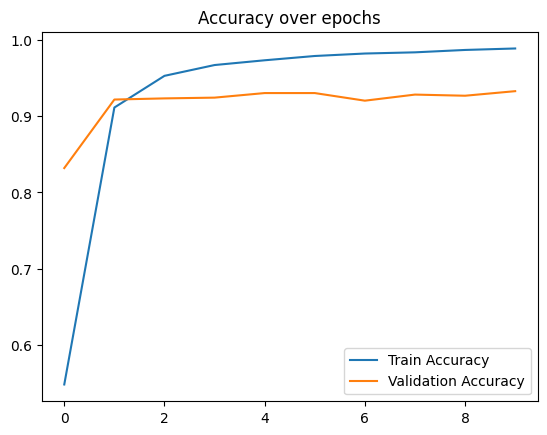

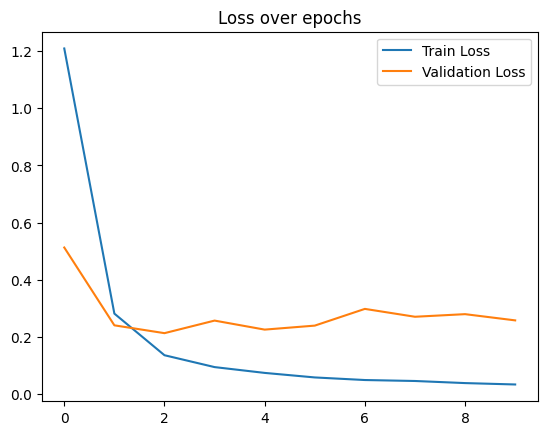

In [17]:
# Accuracy and loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
Classification Report:
              precision    recall  f1-score   support

       anger       0.90      0.92      0.91       275
        fear       0.90      0.88      0.89       224
         joy       0.94      0.95      0.94       695
        love       0.86      0.79      0.82       159
     sadness       0.96      0.96      0.96       581
    surprise       0.74      0.82      0.78        66

    accuracy                           0.92      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.92      0.92      0.92      2000



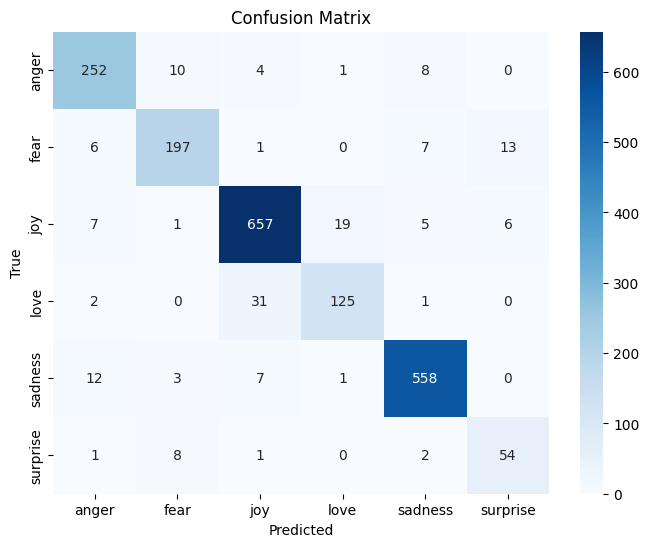

In [18]:
# Test set evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save model

In [19]:
model.save('emotion_lstm_model.h5')
print("Model saved as emotion_lstm_model.h5")

Model saved as emotion_lstm_model.h5


# t-SNE Visualization

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


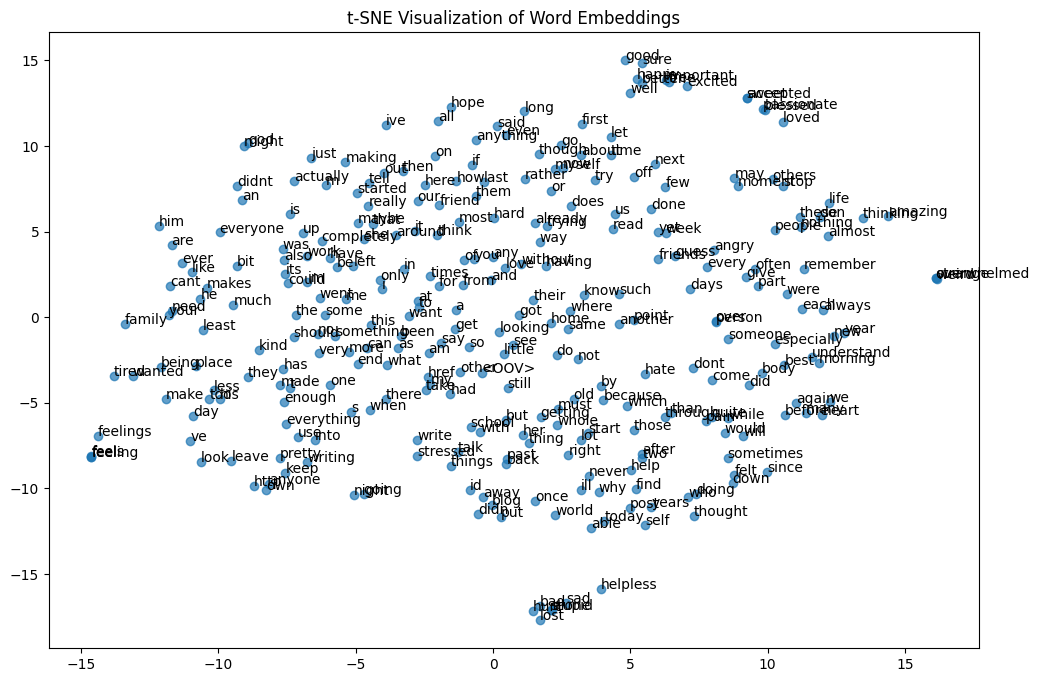

In [20]:
embedding_layer = model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]

# Pick first N words
N = 300
words = list(tokenizer.word_index.keys())[:N]
word_embeddings = embedding_weights[1:N+1]

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(word_embeddings)

plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
for i, word in enumerate(words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.title('t-SNE Visualization of Word Embeddings')
plt.show()